In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
import cv2
from tqdm import tqdm
from skimage.util import montage
from skimage.morphology import label
from math import sqrt

In [4]:
print(os.listdir("./almaz-antey-hackathon-l1"))

['sample_submission.csv', 'test', 'train_segmentation.csv', 'train']


In [5]:
train = os.listdir('./almaz-antey-hackathon-l1/train/train')
print(len(train))

test = os.listdir('./almaz-antey-hackathon-l1/test/test')
print(len(test))

16343
2957


In [6]:
ship_dir = './almaz-antey-hackathon-l1/'
train_image_dir = os.path.join(ship_dir, 'train/train')
test_image_dir = os.path.join(ship_dir, 'test/test')

In [7]:
train_df = pd.read_csv(os.path.join(ship_dir, 'train_segmentation.csv'))
sample_sub = pd.read_csv(os.path.join(ship_dir, 'sample_submission.csv'))

In [8]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-4, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, **kwargs):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros(kwargs['shape'], dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask, **kwargs)
    return all_masks

def masks_as_color(in_mask_list, **kwargs):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros(kwargs['shape'], dtype = np.float)
    scale = lambda x: (len(in_mask_list) + x + 1) / (len(in_mask_list) * 2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask, **kwargs)
    return all_masks

In [9]:
def ship_generator(database, image_path, batch_size=9):
    all_batches = list(database.groupby('ImageId'))
    out_rgb = []
    out_masks = []
    while True:
        np.random.shuffle(all_batches)  # shuffle
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(image_path, c_img_id)
            c_img = imread(rgb_path)
            c_mask = np.expand_dims(masks_as_color(c_masks['EncodedPixels'].values, shape=(768, 768)), -1)
                
            out_rgb += [c_img]
            out_masks += [c_mask]
            if len(out_rgb) >= batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_masks, 0)
                out_rgb = []
                out_masks = []

In [10]:
def plot_one_example(gen):
    
    # init random generator
    if gen is None:
        raise ValueError('set data generator')
        
    train_x, train_y = next(gen)
    print('x', train_x.shape, train_x.min(), train_x.max())
    print('y', train_y.shape, train_y.min(), train_y.max())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
    batch_rgb = montage_rgb(train_x)

    batch_seg = montage(train_y[:, :, :, 0])
    ax1.imshow(batch_rgb)
    ax1.set_title('Images')
    ax2.imshow(batch_seg)
    ax2.set_title('Segmentations')
    plt.show()

In [11]:
generator = ship_generator(train_df, train_image_dir, batch_size=4)

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0.0 1.0


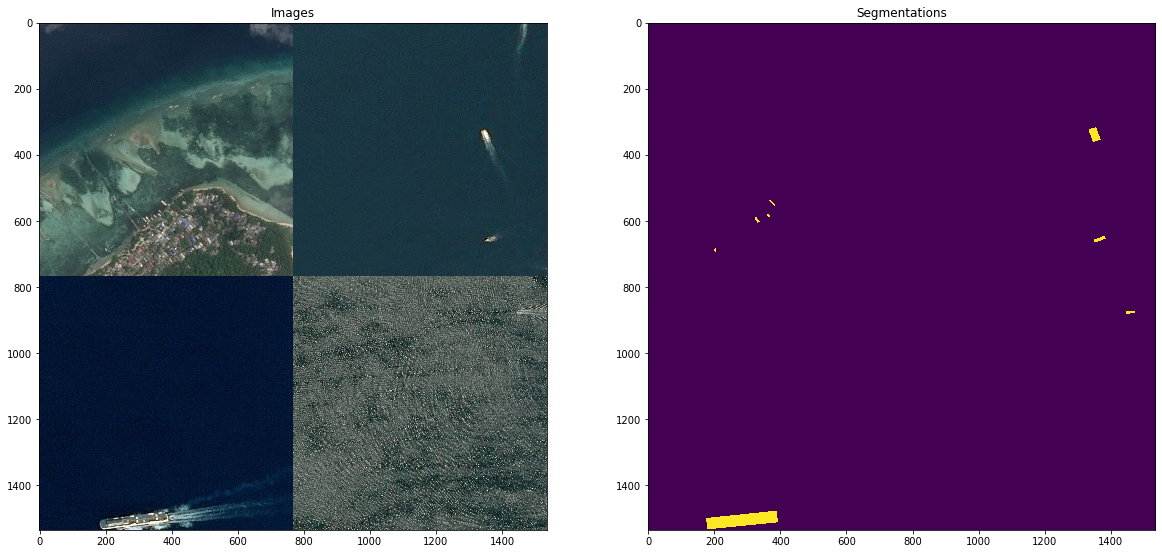

In [12]:
plot_one_example(generator)

In [14]:
def find_mask(fname):
    img_rgb = imread(fname)  
    img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    
    if img[..., 1].mean() < 100: 
        # т.е. для изображений с преобладающим засветлением и, соответственно водой не цвета в окрестности синего
        mask = cv2.medianBlur(img.copy(), 11)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((9, 9), np.uint8))
        mask = cv2.inRange(mask, (0, 0, 180), (180, 50, 255))
        
    else:
        mask = ~cv2.inRange(img, (60, 20, 0), (130, 255, 200))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((7, 7)))
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((21, 21)))
        
    laplac = cv2.Laplacian(mask, cv2.THRESH_BINARY, scale=0.55, ksize=3)
    contours, hierarchy = cv2.findContours(laplac, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for cont in contours:
        x,y,w,h = cv2.boundingRect(cont)
        avr = np.array(cv2.mean(img[y:y+h,x:x+w])).astype(np.uint8)
        area = cv2.contourArea(cont)
        hull = cv2.convexHull(cont)
        hull_area = cv2.contourArea(hull)
        if hull_area:
            solidity = float(area) / hull_area
        else:
            continue

        tmp_1 = avr[0] < 57
        tmp_2 = avr[1] < 70
        tmp_3 = avr[2] > 93
        if solidity < 0.6 and tmp_1 and tmp_2 and tmp_3:
            artefact_mask = np.zeros(mask.shape, np.uint8)
            artefact_mask = ~cv2.drawContours(artefact_mask, [cont], 0, 255, -1)
            mask = cv2.bitwise_and(mask, artefact_mask)

    
                
    #mask = cv2.bitwise_and(mask, noise)
        
    return img_rgb, mask

 67%|██████▋   | 20/30 [00:02<00:01,  8.81it/s]/home/liza/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys
100%|██████████| 30/30 [00:03<00:00, 10.58it/s]


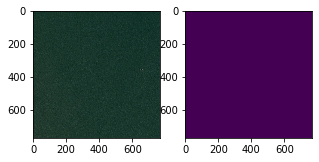

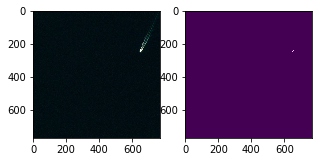

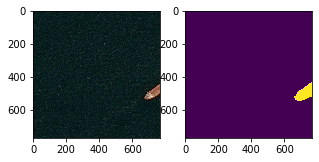

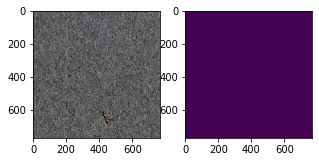

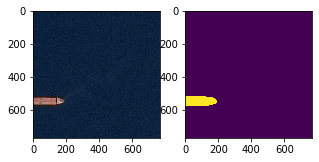

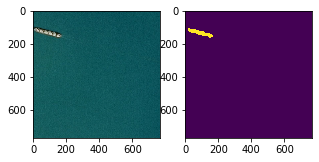

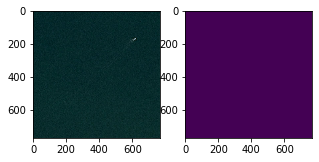

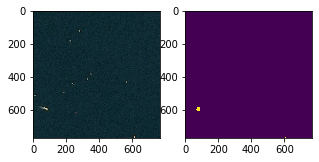

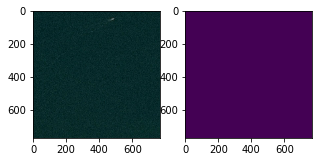

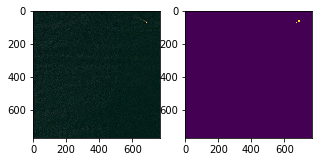

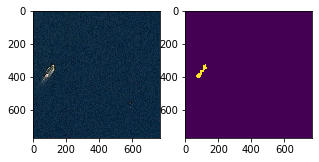

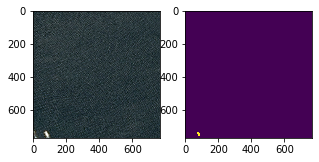

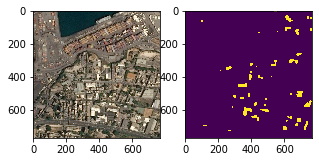

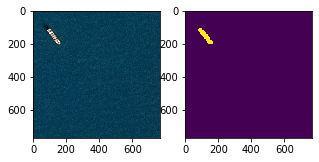

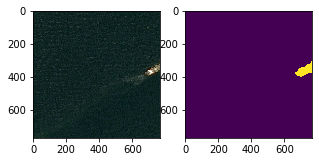

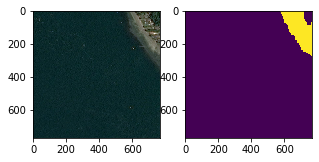

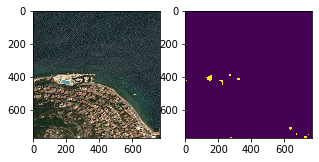

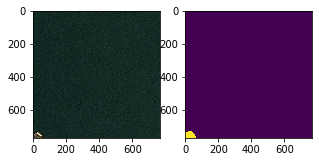

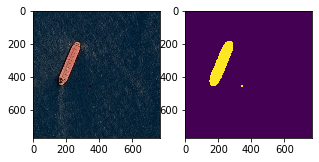

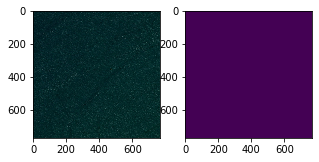

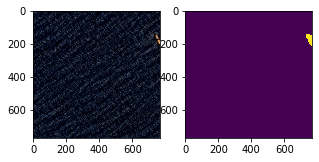

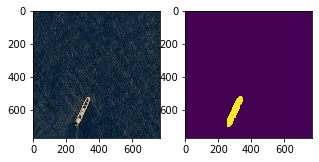

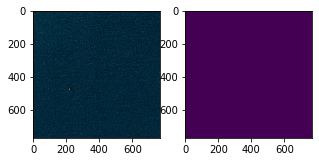

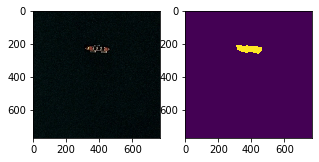

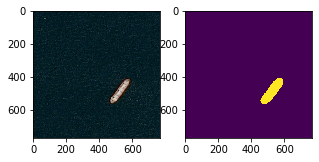

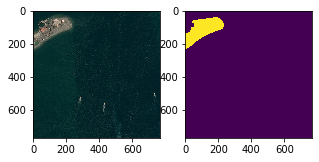

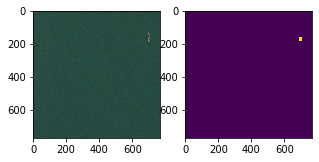

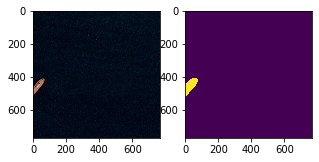

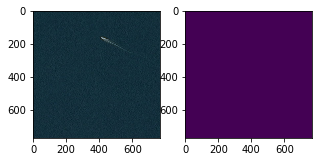

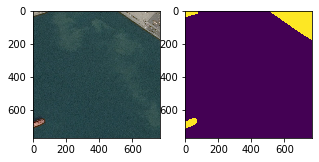

In [16]:
pbar = tqdm(sample_sub.index[120:150])

for idx in pbar:  
    fpath = os.path.join(test_image_dir, sample_sub.iloc[idx].ImageId)
    image, mask = find_mask(fpath)
    
    plts = plt.subplots(1, 2, figsize=(5, 3))[1]
    plts[0].imshow(image)
    plts[1].imshow(mask)

In [17]:
def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union


In [18]:
val_data = train_df.sample(200, replace=False).reset_index()
val_data.EncodedPixels = val_data.EncodedPixels.map(lambda x: rle_decode(x))

In [19]:
pbar = tqdm(val_data.index)

predicts = []
for idx in pbar:  
    fpath = os.path.join(train_image_dir, val_data.iloc[idx].ImageId)
    image, mask = find_mask(fpath)
    predicts.append(mask)


100%|██████████| 200/200 [00:13<00:00, 19.77it/s]


In [20]:
dice = np.mean([dice_coef2(y, predict) for y, predict in zip(val_data.EncodedPixels.to_numpy(), predicts)])

In [21]:
print(f'DICE = {dice}')

DICE = 0.5173153897955081


In [22]:
pbar = tqdm(sample_sub.index[:])

for idx in pbar:  
    fpath = os.path.join(test_image_dir, sample_sub.iloc[idx].ImageId)
    image, mask = find_mask(fpath)
        
    encode_mask = rle_encode(mask)
    sample_sub.iloc[idx].EncodedPixels = encode_mask

100%|██████████| 2829/2829 [01:57<00:00, 24.15it/s]


In [23]:
sample_sub.to_csv('submission.csv', index=False)